# Calculating Accuracy for the Mahalanobis Distance-based Classifier  
In this script, I trained a Mahalanobis distance-based classifier using 80% of the training dataset and evaluated its performance on the remaining 20% by computing accuracy and other relevant metrics.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata as ad

from scipy.spatial.distance import mahalanobis
import numpy.linalg as linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import functools
from scipy.spatial.distance import mahalanobis
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_fscore_support

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(7, 4))
sc.settings.verbosity = 3

-----
anndata     0.10.8
scanpy      1.10.1
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
astunparse                  1.6.3
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
bottleneck                  1.3.7
brotli                      1.0.9
certifi                     2024.08.30
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.10.0
cython_runtime              NA
dask                        2024.7.0
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
executing                   0.8.3
fastjsonschema              NA
fqdn                        NA
h5py                        3.9.0
id

#### I imported the training dataset and created a duplicate variable. The first variable, `train`, will be used for feature selection, while the second, `trainraw`, will be designated for actual training. This dataset was generated in the notebook titled `fron_no_adolescence_to_final_training_dataset.ipynb`.

In [3]:
train = sc.read_h5ad(
    '/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/noAdolescence_nocc_noclusters_ThirdManualAnnotations_Interneurons.h5ad')
trainraw = train.copy()

## Step 1: Splitting the data.

In [4]:
def split_anndata_by_cell_type(train, cell_type_column='ThirdManualAnnotations', split_ratio=0.8, random_state=None):
    
    np.random.seed(random_state)
    
    indices_train1 = []
    indices_train2 = []

    cell_types = train.obs[cell_type_column].unique()
    
    for cell_type in cell_types:
        cell_type_indices = train.obs.index[train.obs[cell_type_column] == cell_type].tolist()
        
        np.random.shuffle(cell_type_indices)

        split_index = int(len(cell_type_indices) * split_ratio)

        indices_train1.extend(cell_type_indices[:split_index])
        indices_train2.extend(cell_type_indices[split_index:])

    train1 = train[indices_train1].copy()
    train2 = train[indices_train2].copy()
    
    return train1, train2

In [5]:
train, test = split_anndata_by_cell_type(train, random_state=42)
trainraw = train.copy()

## Step 2: Feature selection.

In [6]:
ccGenesHuman = np.loadtxt('/hpc/hers_basak/rnaseq_data/Silettilab/samples/final_useful_datasets/ccGenesHuman.txt', dtype=str)
train = train[:, ~np.isin(train.var_names, ccGenesHuman)]

In [7]:
cc2 = ['CCND2', 'TFDP2']
train = train[:, ~np.isin(train.var_names, cc2)]

In [8]:
badGenes = [el for el in train.var_names 
            if el.startswith(('MT-', 'RP', 'TUB')) or el in {'MALAT1', 'EGFR'}]

train = train[:, ~np.isin(train.var_names, badGenes)]

In [9]:
sc.pp.normalize_total(train, target_sum=1e4)
sc.pp.log1p(train)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:19)


In [10]:
sc.pp.highly_variable_genes(train, min_mean=0.0125, max_mean=3, min_disp=0.5, n_top_genes=4000)
train = train[:, train.var.highly_variable]

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [11]:
sc.tl.rank_genes_groups(train, groupby="ThirdManualAnnotations",method= 'logreg', use_raw=False)
sc.tl.filter_rank_genes_groups(train,  max_out_group_fraction=0.2)

ranking genes


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:640: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:54)
Filtering genes using: min_in_group_fraction: 0.25 min_fold_change: 1, max_out_group_fraction: 0.2


/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
filtered_genes = {}
for group in train.uns['rank_genes_groups_filtered']['names'].dtype.names:
    genes = train.uns['rank_genes_groups_filtered']['names'][group]
    filtered_gene_list = [gene for gene in genes if pd.notnull(gene)]
    filtered_genes[group] = filtered_gene_list[:25]
filtered_genes = list(set([item for sublist in filtered_genes.values() for item in sublist]))

In [13]:
aleGenes = ['AQP4','ADGRV1','MGST1','SPARCL1','ID3','CST3','BCAN', 'VEGFA','LGALS1','LGALS3', 'ETV1','PTPRZ1','ITM2C','HOPX','VIM','CLU', 
            'CDK4','SOX2','STMN1','STMN2', 'ASCL1','HES1','NHLH1','NRXN3','RBP1', 'PLP1', 'OLIG1','OLIG2','SOX10','PDGFRA', 'ACTA2','FN1','CLDN5',
            'VXN','VWF','ITM2A', 'COL1A1','COL3A1','COL4A1', 'IGHM','IGKC', 'CD3G','CD3D','CD3E','TRAC', 'CD4', 'CD8A','GZMH','GZMK','GNLY','CD74',
            'FTL','SPP1','C1QA','C1QB','C1QC','CSF1R', 'HLA-DRA','HLA-DQB1','FOXM1','TYMS']

In [14]:
myGenes = [
    'LIX1', 'LEF1', 'HEY1', 'CRABP2', 'AMBN', 'TPD52L1', 'SNCG', 'ECEL1', 'CNFN', 'OLFM3',
    'CST3', 'TC', 'ATP1A2', 'SPARCL1', 'APOE', 'NEAT1', 'AQP4', 'SLC4A4', 'GLIS3', 'GRM3',
    'TNC', 'MGAT4C', 'LRIG1', 'GJA1', 'ACSL6', 'NPNT', 'PAQR8', 'COL5A3', 'FRMPD2',
    'CD44', 'GALNT15', 'CD38', 'DAAM2', 'ANGPT1', 'COLEC12', 'AQP1', 'HSPB8',
    'PCDH15', 'OPCML', 'CSMD3', 'CA10', 'FGF14', 'NXPH1', 'TNR', 'FGF12', 'MDGA2',
    'DNM3', 'CNTNAP5', 'NRXN3', 'SGCZ', 'COL20A1', 'CHRM3', 'PDGFRA', 'AFAP1L2', 'APOD',
    'PDGFD', 'LIPG', 'IQGAP2', 'AKAP12', 'NIPY', 'TMTC1', 'FBXO32', 'EVA1C', 'LAMA3',
    'CCDC175', 'ELAVL2', 'SRRM4', 'HES6', 'PLXNA2', 'EOMES', 'EPHA3', 'NHLH1', 'GADD45G',
    'MYT1L', 'RBFOX3', 'ELAVL4', 'SLC22A23', 'PGP13', 'KCNB2', 'NEUROG1', 'MFNG',
    'MYCL', 'RGS16', 'CREG2', 'GREM2', 'EBF2', 'NHLH2', 'LHX9', 'SPINK5', 'FNDC5',
    'EBF1', 'NRN1', 'CLMP', 'SLA', 'PPP1R17', 'SL17A6', 'NEUROD2', 'NEUROD6',
    'LGR6', 'VAV3', 'ADCY1', 'RGS6', 'KLHL4', 'GAD1', 'ATP2C2', 'GALR1', 'DBX2',
    'SLC6A11', 'ST8SIA5', 'CCDC80', 'MATN2', 'CAPS2',
    'DLL3', 'ASCL1', 'CCDC178', 'GSG1L', 'RFTN1', 'IGSF9B', 'ANGEL1', 'CASP9',
    'KIRREL3', 'DPF3', 'SLIT1', 'IRX1', 'VIPR2', 'DLX6', 'DLX6-AS1', 'DLX5', 'GAD1', 'GAD2', 'GAD45G'
]

In [15]:
selectedGenes = np.unique(np.concatenate((aleGenes, filtered_genes, myGenes)))

In [16]:
selectedGenes = functools.reduce(np.intersect1d, (selectedGenes, trainraw.var_names))
trainraw = trainraw[:, selectedGenes]
test = test[:, selectedGenes]

In [17]:
sc.pp.normalize_total(trainraw, target_sum=1e4)
sc.pp.log1p(trainraw)

sc.pp.normalize_total(test, target_sum=1e4)
sc.pp.log1p(test)

/hpc/hers_basak/rnaseq_data/Silettilab/icoratella/miniconda3/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


## Step 3: training of the model on `trainraw`.

In [18]:
train_X_dense = trainraw.X.toarray()
test_X_dense = test.X.toarray()

scaler = StandardScaler(with_mean=True, with_std=True)

train_scaled = scaler.fit_transform(train_X_dense)
test_scaled = scaler.transform(test_X_dense)

In [19]:
pca = PCA(n_components=50, svd_solver='auto',  random_state=42)

train_pca = pca.fit_transform(train_scaled)
trainraw.obsm['X_pca'] = train_pca

test_pca = pca.transform(test_scaled)
test.obsm['X_pca'] = test_pca

In [20]:
pca_projections = trainraw.obsm['X_pca']
cell_types = trainraw.obs['ThirdManualAnnotations'].unique()

means = {}
covariances = {}

for cell_type in cell_types:
    subset_indices = trainraw.obs['ThirdManualAnnotations'] == cell_type
    subset_pca = pca_projections[subset_indices]
   
    mean_vector = np.mean(subset_pca, axis=0)
    covariance_matrix = np.cov(subset_pca, rowvar=False)
    means[cell_type] = mean_vector
    covariances[cell_type] = covariance_matrix

## Step 4: testing of the model

In [21]:
def classify_single_cell(cell, means, covariances, scale=1.0):

    distances = {}
    affinities = {}
    affinities2 = {}
    
    # Calculate distances and convert them into affinity scores for each cell class.
    for cell_type, mean in means.items():
        inv_cov = linalg.pinv(covariances[cell_type])
        d = mahalanobis(cell, mean, inv_cov)
        distances[cell_type] = d
        # Step 1 of softmax: affinity score calculated as the exponential of the negative distance (scaled). Save all the info for all classes.
        affinities[cell_type] = np.exp(-scale * d)
    
    # Step 1 of softmax: normalization: each probability for each class is given by the affinity divided by the total sum of affinities
    total_affinity = sum(affinities.values())
    probabilities = {ct: aff / total_affinity for ct, aff in affinities.items()}
    
    # The best_match is the cell type with the highest probability (corresponds to the minimum distance)
    best_match = max(probabilities, key=probabilities.get)
    best_probability = probabilities[best_match]
    min_distance = distances[best_match]
    
    return best_match, best_probability, min_distance, distances, probabilities

In [22]:
def classify_tumor_cells(tumor_pca_data, means, covariances, scale=1.0):
    # Determine the total number of tumor cells to classify.
    total_cells = len(tumor_pca_data)
    print(f"Total number of tumor cells to classify: {total_cells}")

    # Set the block size and compute the number of blocks needed.
    block_size = 1000
    num_blocks = (total_cells + block_size - 1) // block_size

    # Initialize lists to accumulate results from each block.
    classifications = []
    best_probabilities = []
    min_distances = []
    all_distances = []
    all_probabilities = []

    # Process cells in blocks to efficiently handle large datasets.
    for i in range(num_blocks):
        # Define the start and end indices for the current block.
        start = i * block_size
        end = min(start + block_size, total_cells)
        print(f"Processing block {i + 1}/{num_blocks} cells from {start + 1} to {end}.")

        # Classify each cell in the current block using parallel processing.
        block_results = Parallel(n_jobs=-1)(
            delayed(classify_single_cell)(cell, means, covariances, scale)
            for cell in tumor_pca_data[start:end]
        )

        # Unpack the results from the block into separate variables.
        (block_classifications, block_best_probabilities, block_min_distances,
         block_all_distances, block_all_probabilities) = zip(*block_results)

        # Append the current block's results to the overall lists.
        classifications.extend(block_classifications)
        best_probabilities.extend(block_best_probabilities)
        min_distances.extend(block_min_distances)
        all_distances.extend(block_all_distances)
        all_probabilities.extend(block_all_probabilities)

    # Signal the completion of the classification process.
    print("Classification complete.")
    return classifications, best_probabilities, min_distances, all_distances, all_probabilities

In [ ]:
classifications, best_probabilities, min_distances, all_distances, all_probabilities = classify_tumor_cells(
    test.obsm['X_pca'], means, covariances, scale=0.3
)

In [24]:
test.obs['predictions_MD'] = classifications
test.obs['max_probability_MD'] = best_probabilities
test.obs['all_distances_MD'] = all_distances
test.obs['all_probabilities_MD'] = all_probabilities
test.obs['min_distance_MD'] = min_distances

## Step 4: evaluation of the results.

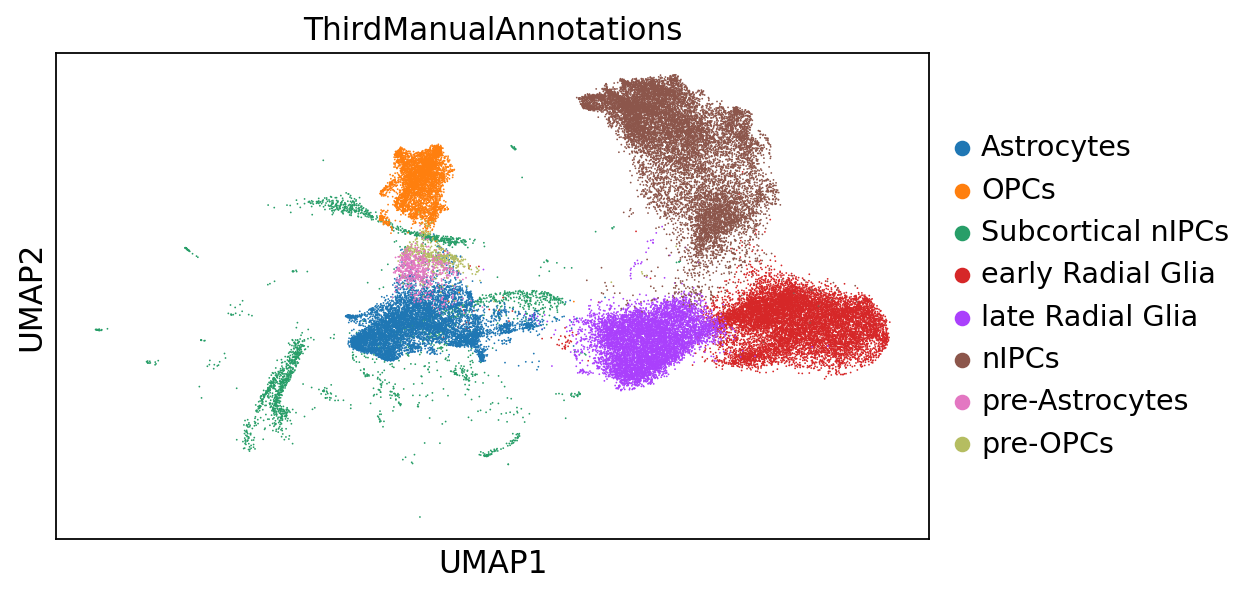

In [25]:
sc.pl.embedding(test, basis = 'UMAP', color = 'ThirdManualAnnotations')

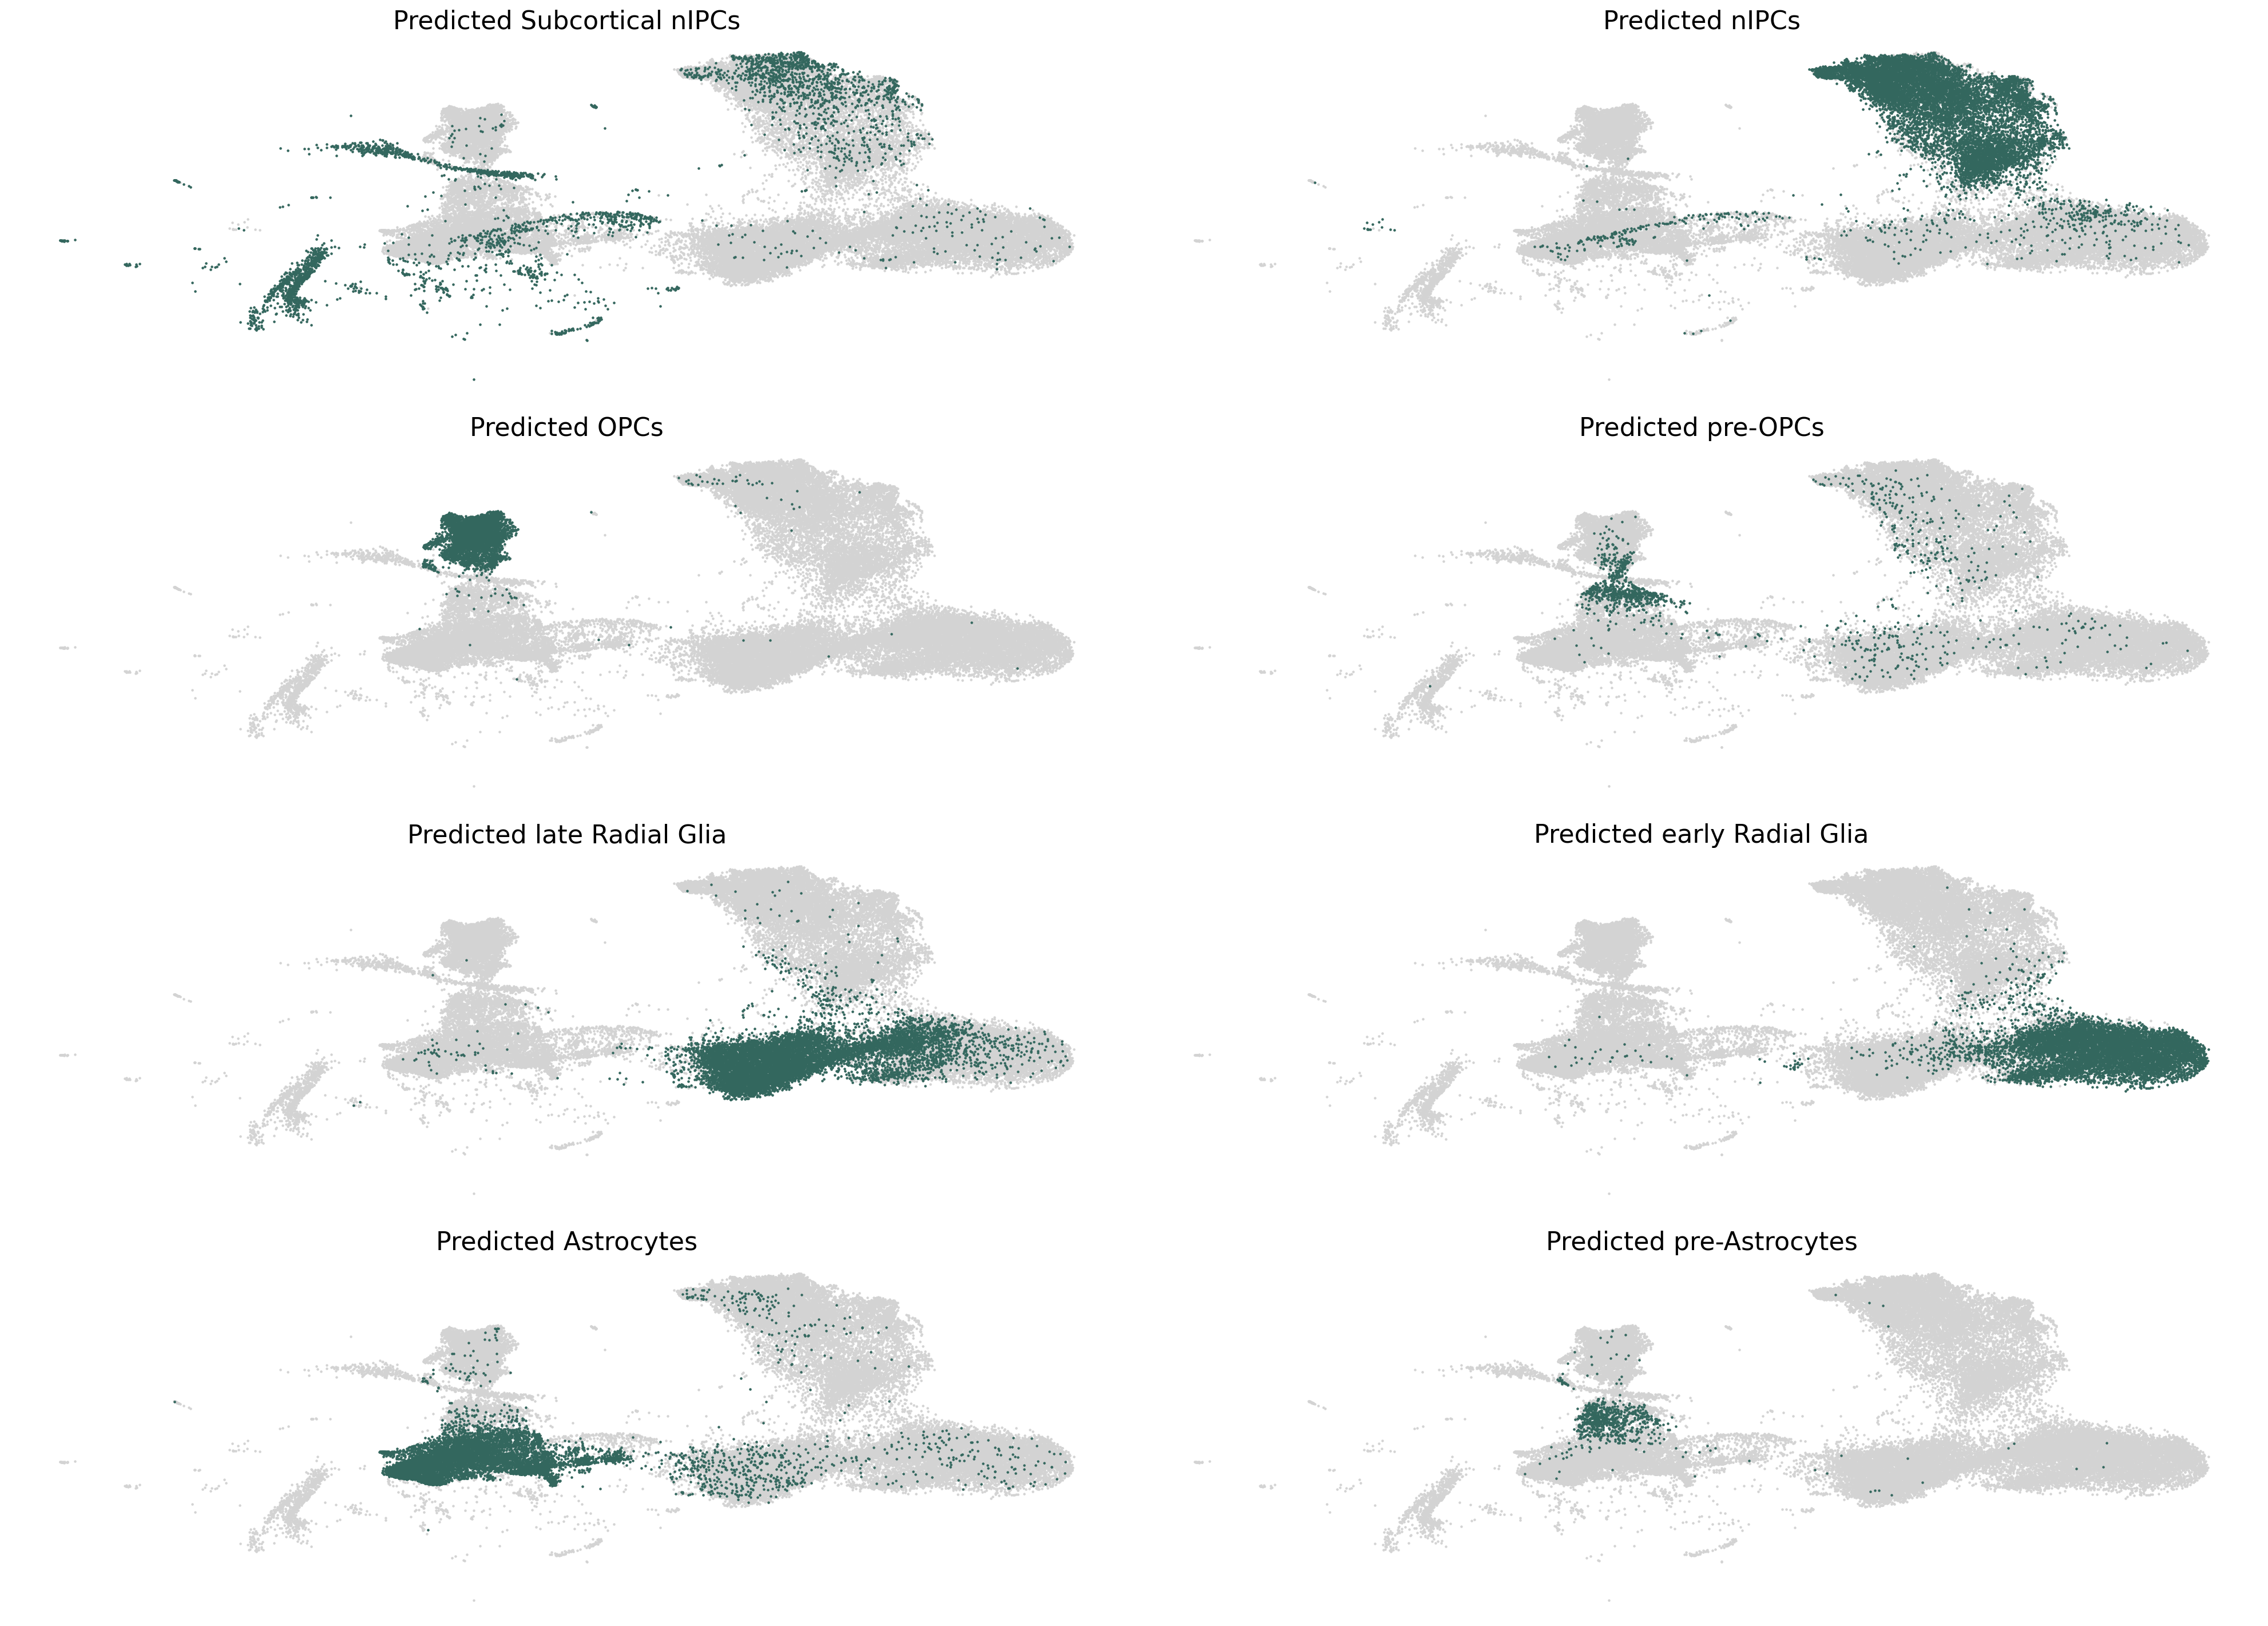

In [26]:
unique_predictions = test.obs['predictions_MD'].unique()
n_rows = (len(unique_predictions) + 1) // 2
n_cols = 2

fig, axs = plt.subplots(n_rows, n_cols, figsize=(25, 18))
axs = axs.flatten()

for i, prediction in enumerate(unique_predictions):
    ax = axs[i]
    ax.scatter(test.obsm['UMAP'][:, 0], test.obsm['UMAP'][:, 1], s=1, color="lightgray", label='Other cells')
    
    is_predicted_class = test.obs['predictions_MD'] == prediction
    ax.scatter(test.obsm['UMAP'][is_predicted_class, 0], test.obsm['UMAP'][is_predicted_class, 1], s=1, color='#33675e', label=f'Predicted {prediction}')
    
    ax.set_title(f'Predicted {prediction}', fontsize=20)
    ax.axis('off')

for ax in axs[len(unique_predictions):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

#plt.savefig('MD_accuracy_plot.png', dpi = 600)

In [27]:
def calculate_label_match_accuracy(test, label_column='ThirdManualAnnotations', prediction_column='classifications'):

    true_labels = test.obs[label_column]
    predicted_labels = test.obs[prediction_column]
    
    accuracy = np.mean(true_labels == predicted_labels)
    return accuracy

In [28]:
accuracy = calculate_label_match_accuracy(test, 'ThirdManualAnnotations', 'predictions_MD')

In [29]:
accuracy

0.8440805833017238

In [30]:
def generate_classification_report(y_true, y_pred, classes):
    
    precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, labels=classes)

    report = "classification report\n\n"
    report += f"{'Class':<20}{'Precision':<10}{'Recall':<10}{'F1-score':<10}{'Support':<10}\n"
    
    for i, label in enumerate(classes):
        report += f"{label:<20}{precision[i]:<10.2f}{recall[i]:<10.2f}{f1_score[i]:<10.2f}{support[i]:<10}\n"
    
    return report

In [31]:
y_true = test.obs['ThirdManualAnnotations']
y_pred = test.obs['predictions_MD']

classes = unique_predictions

report = generate_classification_report(y_true, y_pred, classes)
print(report)

classification report

Class               Precision Recall    F1-score  Support   
Subcortical nIPCs   0.60      0.91      0.72      2630      
nIPCs               0.95      0.82      0.88      12969     
OPCs                0.98      0.94      0.96      4186      
pre-OPCs            0.38      0.82      0.52      545       
late Radial Glia    0.73      0.88      0.80      7973      
early Radial Glia   0.95      0.73      0.83      10907     
Astrocytes          0.88      0.94      0.91      7629      
pre-Astrocytes      0.54      0.69      0.61      615       



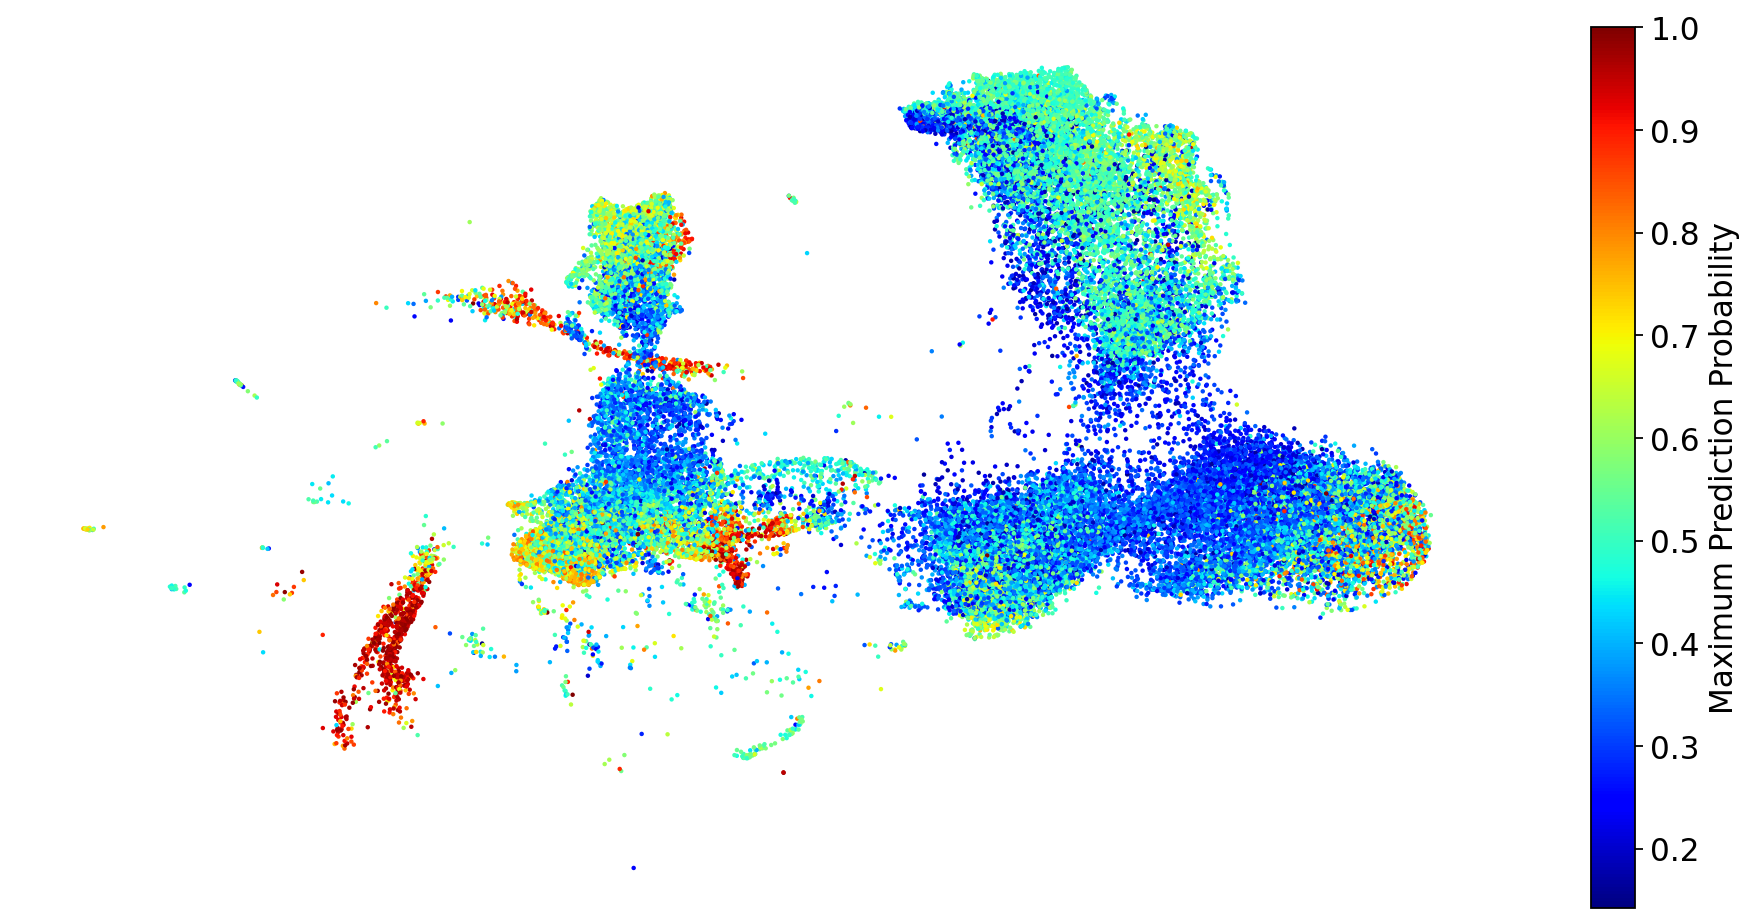

In [32]:
plt.figure(figsize=(12, 6))
sc = plt.scatter(test.obsm['UMAP'][:, 0], test.obsm['UMAP'][:, 1],
                 c=test.obs['max_probability_MD'], cmap='jet', s=1)

plt.colorbar(sc, label='Maximum Prediction Probability')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.axis('off')
plt.tight_layout()
plt.show()